In [159]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import torch
import zarr
import h5py
import numpy as np
import pandas as pd
import scipy.ndimage
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from omegaconf import OmegaConf
from scipy.ndimage import gaussian_filter
from torch.utils.data import DataLoader

from brainage.model.model3d import AgeModel3DVolume
from brainage.dataset.grid3d import GridPatchSampler, DataReaderHDF5

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [152]:
data_dir = Path('/mnt/qdata/raheppt1/data/brainage/nako/')
data_path = data_dir/'interim/t1_pp_10_cropped.h5'
maps_path = data_dir/'processed/gradcam/patchwise/maps.zarr'

In [205]:
pred_patch = pd.read_feather(data_dir/'processed/gradcam/patchwise/predictions_regional.feather')
pred_volume = pd.read_feather(data_dir/'processed/gradcam/volume/predictions.feather')

### Single subject

In [206]:
with h5py.File(data_path, 'r') as hf:
    with zarr.open(str(maps_path)) as zf:
        keys = list(zf['agemaps'])
        agemaps = zf['agemaps'][key][:]
        gradmaps = zf['gradmaps'][key][:]
        g_min = np.min(gradmaps)
        g_max = np.max(gradmaps)
        gradmaps = (gradmaps - g_min)/(g_max - g_min)
        mri = hf['image'][key][:]
a_c = pred_volume[pred_volume['key']==key]['y'].item()
a_p = pred_volume[pred_volume['key']==key]['y_hat0'].item()


In [207]:
key = keys[0]
pred_volume[pred_volume['key']==key]

,key,y,y_hat0,y_hat1
0,100000,52.0,49.465534,0.885896


chronological age 52.00 49.47


Text(0.5, 1.0, 'regional age')

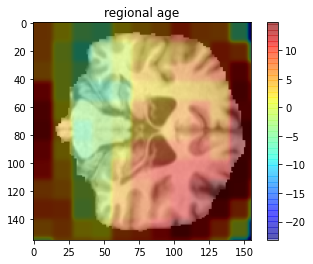

In [208]:
sl = 80
sigma = 1.5
print(f'chronological age {a_c:.2f} {a_p:.2f}')
plt.imshow(mri[:,sl,:].astype(np.float32), cmap='gray')
smooth_img = np.copy(agemaps[0][:,sl,:])
smooth_img = gaussian_filter(smooth_img - a_p, sigma=sigma)
plt.imshow(smooth_img, cmap='jet', alpha=0.4)
plt.colorbar()
plt.title('regional age')

Text(0.5, 1.0, 'regional uncertainty')

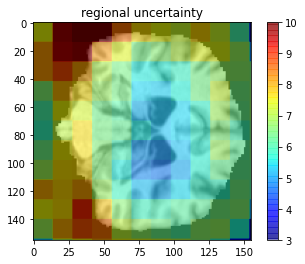

In [209]:
sl = 80
plt.imshow(mri[:,sl,:].astype(np.float32), cmap='gray')
plt.imshow(np.exp(agemaps[1,:,sl,:]),vmin=3, vmax=10, cmap='jet', alpha=0.5)
plt.colorbar()
plt.title('regional uncertainty')

Text(0.5, 1.0, 'grad cam')

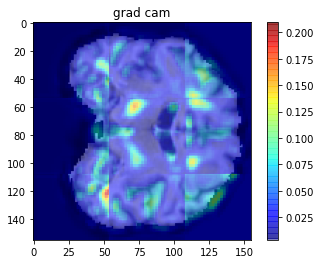

In [210]:
sl = 100
plt.imshow(mri[:,sl,:].astype(np.float32), cmap='gray')
plt.imshow(gradmaps[0,:,sl,:], cmap='jet', alpha=0.5)
plt.colorbar()
plt.title('grad cam')

### Average

In [212]:
gradmaps_mean = np.zeros([1, 155, 185, 155])
agemaps_mean = np.zeros([1, 155, 185, 155])
img_mean = np.zeros([1, 155, 185, 155])
with h5py.File(data_path, 'r') as hf:
    with zarr.open(str(maps_path)) as zf:
        keys = list(zf['agemaps'])
        for key in tqdm(keys):
            a_c = pred_volume[pred_volume['key']==key]['y'].item()
            a_p = pred_volume[pred_volume['key']==key]['y_hat0'].item()     
            agemaps = zf['agemaps'][key][:] - a_p
            gradmaps = zf['gradmaps'][key][:]
            img = hf['image'][key][:]
            g_min = np.min(gradmaps)
            g_max = np.max(gradmaps)
            gradmaps_mean = gradmaps_mean + (gradmaps - g_min)/(g_max - g_min)
            img_mean = img_mean + img
            agemaps_mean = agemaps_mean + agempas
    gradmaps_mean = gradmaps_mean/len(keys)
    img_mean = img_mean/len(keys)
    agemaps_mean = agemaps_mean/len(keys)

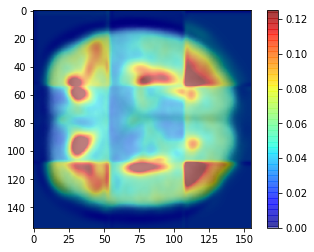

In [224]:
sl = 50
sigma = 1.0
tmp = np.copy(gradmaps_mean[0])
plt.imshow(img_mean[0, :,sl,:], cmap='gray')
plt.imshow(gaussian_filter(tmp, sigma=sigma)[:,sl,:], alpha=0.5, vmin=0.0, vmax=0.125, cmap='jet')
plt.colorbar()

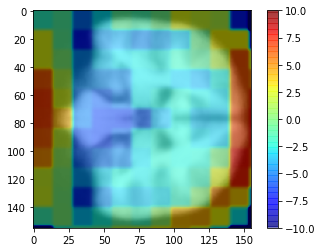

In [225]:
sl = 80
sigma = 1.0
tmp = np.copy(agemaps_mean[0])
plt.imshow(img_mean[0, :,sl,:], cmap='gray')
plt.imshow(gaussian_filter(tmp, sigma=sigma)[:,sl,:], vmin=-10, vmax=10, alpha=0.5, cmap='jet')
plt.colorbar()